In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from files import read_stock_files, write_transaction_file, read_transaction_file
from trade import evaluate_transactions

In [2]:
transactions = read_transaction_file('../test_small.txt')

In [3]:
stocks_df = read_stock_files('../Stocks')

  0%|          | 0/7195 [00:00<?, ?it/s]

100%|██████████| 7195/7195 [00:17<00:00, 404.36it/s]


In [4]:
# drop stocks with less than a year of data
stocks_df = stocks_df.groupby('Name').filter(lambda x: len(x) >= 252)

# drop rows
stocks_df.drop(
    index=stocks_df.loc[
        (stocks_df[["Low", "High", "Open", "Close", "Volume"]] <= 0).any(axis=1) | 
        (stocks_df['Low'] > stocks_df['High']) | 
        (stocks_df['Volume'] < 10) | 
        (stocks_df['High'] > 10 * stocks_df['Low'])
    ].index,
    inplace=True,
)
stocks_df.drop(columns=["OpenInt"], inplace=True)
stocks_df.set_index(["Date", "Name"], inplace=True)
#stocks_df.sort_index(level="Date", ascending=True, inplace=True)


In [5]:
#stocks_df['IntraDayDiff_Volume'] = (stocks_df['High'] - stocks_df['Low']) * stocks_df['Volume'] * 0.1

In [6]:
grouped_by_stock = stocks_df.groupby(level=[1])

dff = pd.DataFrame({
    "HighClose": grouped_by_stock['Close'].max(),
    "DateHighClose": grouped_by_stock['Close'].idxmax().apply(lambda i: i[0]),
    "LowClose": grouped_by_stock['Close'].min(),
    "DateLowClose": grouped_by_stock['Close'].idxmin().apply(lambda i: i[0]),
})
dff['Diff'] = (dff['HighClose'] - dff['LowClose'])/dff['LowClose']
dff = dff.loc[dff['DateHighClose'] > dff['DateLowClose'] ]
#stonks = dff.sort_values(by='Diff', ascending=False).head(50) # change that
stonks_names = list(dff.sort_values(by='Diff', ascending=False).head(50).index)
stonks_names.append('ge')

In [7]:
# keep only stonks
stocks_df = stocks_df.loc[pd.IndexSlice[:, stonks_names], :].copy()
stocks_df.sort_index(level="Date", ascending=True, inplace=True)

In [8]:
stocks_df

Open      High       Low     Close   Volume
Date       Name                                                 
1962-01-02 ge      0.6277    0.6362    0.6201    0.6201  2575579
1962-01-03 ge      0.6201    0.6201    0.6122    0.6201  1764749
1962-01-04 ge      0.6201    0.6201    0.6037    0.6122  2194010
1962-01-05 ge      0.6122    0.6122    0.5798    0.5957  3255244
1962-01-08 ge      0.5957    0.5957    0.5716    0.5957  3696430
...                   ...       ...       ...       ...      ...
2017-11-10 unh   211.4600  211.8100  210.2000  211.0700  1384718
           utx   118.0000  118.4800  118.0000  118.1100  3122513
           uve    25.2500   25.4500   24.9500   25.2500   256504
           viav    8.4000    8.6100    8.3400    8.5500  5418048
           wmt    90.2400   91.6900   90.2000   90.9200  7646013

[384693 rows x 5 columns]

In [9]:
stocks_df['AllTimeMaxClose'] = stocks_df.groupby('Name')['Close'].transform('max')
stocks_df['AllTimeMinClose'] = stocks_df.groupby('Name')['Close'].transform('min')
stocks_df['AllTimeMaxCloseDate'] = stocks_df.index.get_level_values('Name').map(
    stocks_df.groupby('Name')['Close'].idxmax().map(lambda x: x[0])
)
stocks_df['AllTimeMinCloseDate'] = stocks_df.index.get_level_values('Name').map(
    stocks_df.groupby('Name')['Close'].idxmin().map(lambda x: x[0])
)
#stocks_df = stocks_df.loc[
#    (stocks_df.index.get_level_values('Date') >= stocks_df['AllTimeMinCloseDate']) & 
#    (stocks_df.index.get_level_values('Date') <= stocks_df['AllTimeMaxCloseDate'])
#].copy()

In [10]:
stocks_df['WantToSell'] = (stocks_df['Close'] - stocks_df['AllTimeMinClose'])/(stocks_df['AllTimeMaxClose'] - stocks_df['AllTimeMinClose'])
stocks_df.loc[stocks_df['WantToSell'] > 0.9, 'WantToSell'] = 1
stocks_df.loc[stocks_df['WantToSell'] < 0.1, 'WantToSell'] = 0
stocks_df['WantToBuy'] = 1 - stocks_df['WantToSell']

stocks_df.loc[stocks_df.index.get_level_values('Date') > stocks_df['AllTimeMaxCloseDate'], 'WantToBuy'] = 0
stocks_df.loc[stocks_df.index.get_level_values('Date') > stocks_df['AllTimeMaxCloseDate'], 'WantToSell'] = 1
stocks_df.loc[stocks_df.index.get_level_values('Date') < stocks_df['AllTimeMinCloseDate'], 'WantToBuy'] = 0
stocks_df.loc[stocks_df.index.get_level_values('Date') < stocks_df['AllTimeMinCloseDate'], 'WantToSell'] = 0

In [11]:
stocks_df

Open      High       Low     Close   Volume  \
Date       Name                                                    
1962-01-02 ge      0.6277    0.6362    0.6201    0.6201  2575579   
1962-01-03 ge      0.6201    0.6201    0.6122    0.6201  1764749   
1962-01-04 ge      0.6201    0.6201    0.6037    0.6122  2194010   
1962-01-05 ge      0.6122    0.6122    0.5798    0.5957  3255244   
1962-01-08 ge      0.5957    0.5957    0.5716    0.5957  3696430   
...                   ...       ...       ...       ...      ...   
2017-11-10 unh   211.4600  211.8100  210.2000  211.0700  1384718   
           utx   118.0000  118.4800  118.0000  118.1100  3122513   
           uve    25.2500   25.4500   24.9500   25.2500   256504   
           viav    8.4000    8.6100    8.3400    8.5500  5418048   
           wmt    90.2400   91.6900   90.2000   90.9200  7646013   

                 AllTimeMaxClose  AllTimeMinClose AllTimeMaxCloseDate  \
Date       Name                                                         
1962-01-02 ge             48.056          0.45902          2000-08-28   
1962-01-03 ge             48.056          0.45902          2000-08-28   
1962-01-04 ge             48.056          0.45902          2000-08-28   
1962-01-05 ge             48.056          0.45902          2000-08-28   
1962-01-08 ge             48.056          0.45902          2000-08-28   
...                          ...              ...                 ...   
2017-11-10 unh           212.870          0.26126          2017-11-03   
           utx           122.960          0.20553          2017-07-12   
           uve            34.076          0.02781          2015-10-23   
           viav          666.460          1.00060          2000-03-06   
           wmt            90.920          0.00821          2017-11-10   

                AllTimeMinCloseDate  WantToSell  WantToBuy  
Date       Name                                             
1962-01-02 ge            1962-06-22         0.0        0.0  
1962-01-03 ge            1962-06-22         0.0        0.0  
1962-01-04 ge            1962-06-22         0.0        0.0  
1962-01-05 ge            1962-06-22         0.0        0.0  
1962-01-08 ge            1962-06-22         0.0        0.0  
...                             ...         ...        ...  
2017-11-10 unh           1990-03-26         1.0        0.0  
           utx           1970-07-06         1.0        0.0  
           uve           2005-02-25         1.0        0.0  
           viav          1994-04-19         1.0        0.0  
           wmt           1974-12-06         1.0        0.0  

[384693 rows x 11 columns]

<Axes: xlabel='None'>

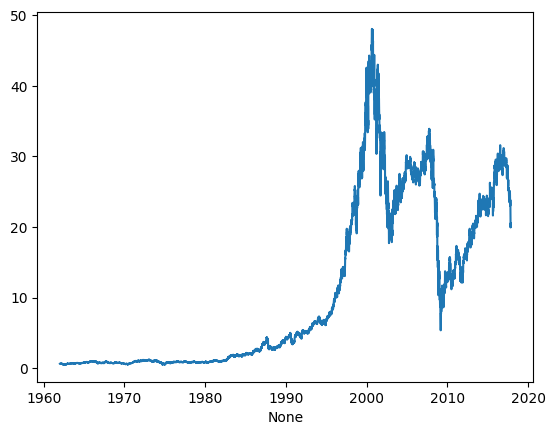

In [12]:
some_stock = stocks_df.query("Name == 'ge'")['Close']
x1, y1 = pd.to_datetime((some_stock.index.map(lambda x: x[0]))), some_stock.values

sns.lineplot(x=x1, y=y1)


<Axes: xlabel='None'>

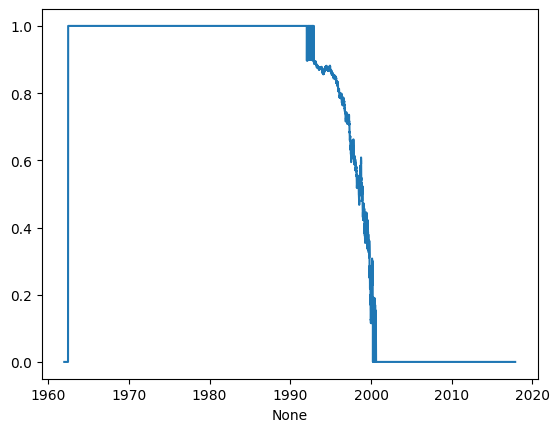

In [15]:
some_stock = stocks_df.query("Name == 'ge'")['WantToBuy']
#some_stock = stocks_df.query("Name == 'ge'")['WantToBuy']
x1, y1 = pd.to_datetime((some_stock.index.map(lambda x: x[0]))), some_stock.values

sns.lineplot(x=x1, y=y1)


In [155]:
# intra buy open sell high
stocks_df.loc[
    (stocks_df["Open"] == stocks_df["Low"]) & (stocks_df["IntraDayDiff_Volume"] > 1000)
].sort_values(by="IntraDayDiff_Volume", ascending=False).index.map(lambda x: x[0])#.sort_values()[:100]

DatetimeIndex(['2008-10-10', '2001-09-17', '2009-03-10', '2008-09-16',
               '2008-10-24', '2009-02-24', '2005-09-15', '2014-01-10',
               '2008-01-22', '2004-12-02',
               ...
               '2012-04-18', '1992-11-05', '2017-08-21', '2005-10-24',
               '2015-09-25', '2013-02-20', '2013-05-24', '2008-05-14',
               '2015-04-23', '2008-01-29'],
              dtype='datetime64[ns]', length=890335, freq=None)

In [144]:
# intra buy low sell close
stocks_df.loc[(stocks_df['Close'] == stocks_df['High']) & (stocks_df['IntraDayDiff_Volume'] > 10)].sort_values(by='IntraDayDiff_Volume', ascending=False)

,,Open,High,Low,Close,Volume,IntraDayDiff_Volume
Date,Name,,,,,,
2009-03-10,brk-b,46.500,55.100,46.500,55.100,251250002,2.160750e+08
2009-05-08,wfc,19.978,23.428,19.813,23.428,575130973,2.079098e+08
2008-11-13,brk-b,66.020,68.500,62.220,68.500,215250000,1.351770e+08
2009-05-04,wfc,16.992,20.163,16.845,20.163,353689292,1.173541e+08
2008-09-19,brk-b,89.800,91.900,85.600,91.900,175249999,1.104075e+08
...,...,...,...,...,...,...,...
2013-08-06,byfc,0.800,0.800,0.760,0.800,2500,1.000000e+01
2011-06-03,nviv,2.800,3.000,2.800,3.000,500,1.000000e+01
2006-06-15,plg,14.500,14.900,14.500,14.900,250,1.000000e+01


In [4]:
portfolio = evaluate_transactions(stocks_df, transactions)
print(portfolio.get_balance()) # 570.371,72741 
print(portfolio.get_evaluation(stocks_df, '2017-11-01')) 

Transaction(day='1962-06-27', transaction_type='buy-low', stock='ge', count=2)
Open      4.590200e-01
High      4.669000e-01
Low       4.590200e-01
Close     4.669000e-01
Volume    2.122467e+06
Name: (1962-06-27 00:00:00, ge), dtype: float64
Transaction(day='1965-12-31', transaction_type='sell-high', stock='ge', count=2)
Open      9.903000e-01
High      9.984000e-01
Low       9.822000e-01
Close     9.822000e-01
Volume    2.444411e+06
Name: (1965-12-31 00:00:00, ge), dtype: float64
Transaction(day='1970-05-27', transaction_type='buy-low', stock='ge', count=4)
Open      5.074000e-01
High      5.313000e-01
Low       4.989200e-01
Close     5.233000e-01
Volume    6.546261e+06
Name: (1970-05-27 00:00:00, ge), dtype: float64
Transaction(day='1973-01-11', transaction_type='sell-high', stock='ge', count=4)
Open      1.223800e+00
High      1.264100e+00
Low       1.223800e+00
Close     1.223800e+00
Volume    5.729467e+06
Name: (1973-01-11 00:00:00, ge), dtype: float64
Transaction(day='1974-09-13'